In [200]:
# Load the TensorBoard notebook extension.

%reload_ext tensorboard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns
import tensorboard
tensorboard.__version__

'2.4.0'

In [201]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = tf.keras.backend.abs(error) < clip_delta
        squared_loss = 0.5 * tf.keras.backend.square(error)
        linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
        return tf.where(cond, squared_loss, linear_loss)
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

### 1) Read dataset original

In [291]:
MicroclimateData = pd.read_csv('./Data/all_buildings_limited.csv')
#add extra features
MicroclimateData['Air Temp Squared'] =  MicroclimateData['Air Temp']**2
MicroclimateData['Abs Hum Squared'] =  MicroclimateData['Abs Hum']**2
MicroclimateData['Air Temp*Abs Hum'] =  MicroclimateData['Air Temp']* MicroclimateData['Abs Hum']
X = MicroclimateData[['bldgname',
              'Air Temp', 
              'Abs Hum',
              'Air Temp Squared',
              'Abs Hum Squared',
              'Air Temp*Abs Hum',
              'DSW Top', 
              'DSW North', 
              'DSW South', 
              'DSW East', 
              'DSW West', 
              'Shade North', 
              'Shade East', 
              'Shade West',
              'Shade South']]
columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
            'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
           'DSW North', 'DSW South', 'DSW East','DSW West',
           'Shade North', 'Shade East', 'Shade West', 'Shade South',]
Y = MicroclimateData['CHWTON/SQFT']
# print(X)
# print(Y.shape)
#scale values
Y = Y.values.reshape(-1, 1)

StdSc2 = StandardScaler()
Y = StdSc2.fit_transform(Y)
X = pd.get_dummies(X)
scaler = StandardScaler()
X[columns] = scaler.fit_transform(X[columns])
# print(X)
# print(Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

### 2) Train Model

In [292]:
model = Sequential()
model.add(Dense(30, input_dim=25, kernel_initializer='he_normal',bias_initializer='he_normal',activation= 'relu'))
model.add(Dense(40, activation = 'relu'))
model.add(Dense(40, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.05))
model.add(Dense(1, activation = 'linear'))
model.compile( loss = huber_loss, optimizer = 'adam')
model.summary()
history = model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=200, 
                            verbose=0, 
                            validation_split=0.2)


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 30)                780       
_________________________________________________________________
dense_75 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_76 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_77 (Dense)             (None, 50)                2050      
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 51        
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
___________________________________________________

In [240]:
def plot_curve():
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history.history["loss"],'r-x', label="Train Loss")
        ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
        ax.legend()
#         ax.set_title(text)
        ax.grid(True)    
#         save_name = "./Data/plots/" + text + ".png"
#         plt.savefig(save_name, bbox_inches='tight')

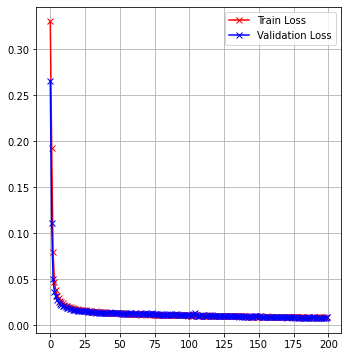

In [15]:
plot_curve()

### 3. Dataset Modification: a) Reduce Temperature b) Shade Increase

In [293]:
#change dataset to reduce air temperature by 1
MicroclimateDataMod = pd.read_csv('./Data/all_buildings_limited.csv')
MicroclimateDataMod['Air Temp'] = MicroclimateDataMod['Air Temp'] + 50.00 #this is where we modify air temperature
MicroclimateDataMod['Air Temp Squared'] =  abs(MicroclimateDataMod['Air Temp']*MicroclimateDataMod['Air Temp'])
MicroclimateDataMod['Abs Hum Squared'] =  MicroclimateDataMod['Abs Hum']**2
MicroclimateDataMod['Air Temp*Abs Hum'] =  MicroclimateDataMod['Air Temp']* MicroclimateDataMod['Abs Hum']
X_new = MicroclimateDataMod[['bldgname',
              'Air Temp', 
              'Abs Hum',
              'Air Temp Squared',
              'Abs Hum Squared',
              'Air Temp*Abs Hum',
              'DSW Top', 
              'DSW North', 
              'DSW South', 
              'DSW East', 
              'DSW West', 
              'Shade North', 
              'Shade East', 
              'Shade West',
              'Shade South']]
columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
            'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
           'DSW North', 'DSW South', 'DSW East','DSW West',
           'Shade North', 'Shade East', 'Shade West', 'Shade South',]
 
X_new = pd.get_dummies(X_new)
X_new[columns] = scaler.fit_transform(X_new[columns])
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, Y, test_size=0.2, random_state=20)

### Change facade name in lines 6-9

In [260]:
#change dataset to add shade to one facade
MicroclimateDataMod = pd.read_csv('./Data/all_buildings_limited.csv')
MicroclimateDataMod['Air Temp Squared'] =  abs(MicroclimateDataMod['Air Temp']*MicroclimateDataMod['Air Temp'])
MicroclimateDataMod['Abs Hum Squared'] =  MicroclimateDataMod['Abs Hum']**2
MicroclimateDataMod['Air Temp*Abs Hum'] =  MicroclimateDataMod['Air Temp']* MicroclimateDataMod['Abs Hum']
shade_list_north = MicroclimateDataMod ['Shade South'].tolist()
shade_list_north = [x + x*0.25 if int(x)!=1.0 else x for x in shade_list_north] 
MicroclimateDataMod .drop('Shade South', axis = 1, inplace = True)
MicroclimateDataMod ['Shade South'] = shade_list_north
X_new = MicroclimateDataMod[['bldgname',
              'Air Temp', 
              'Abs Hum',
              'Air Temp Squared',
              'Abs Hum Squared',
              'Air Temp*Abs Hum',
              'DSW Top', 
              'DSW North', 
              'DSW South', 
              'DSW East', 
              'DSW West', 
              'Shade North', 
              'Shade East', 
              'Shade West',
              'Shade South']]
columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
            'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
           'DSW North', 'DSW South', 'DSW East','DSW West',
           'Shade North', 'Shade East', 'Shade West', 'Shade South',]

scaler1 = StandardScaler() 
Buildings = X_new['bldgname'].unique() 
X_new = pd.get_dummies(X_new)
X_new[columns] = scaler.fit_transform(X_new[columns])
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, Y, test_size=0.2, random_state=20)



## Run below script only once after training. Before running script below, run scripts: 1, 2 and 3(whichever required) , and then run whole cycle again if required.

/home/biswas/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/biswas/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/biswas/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

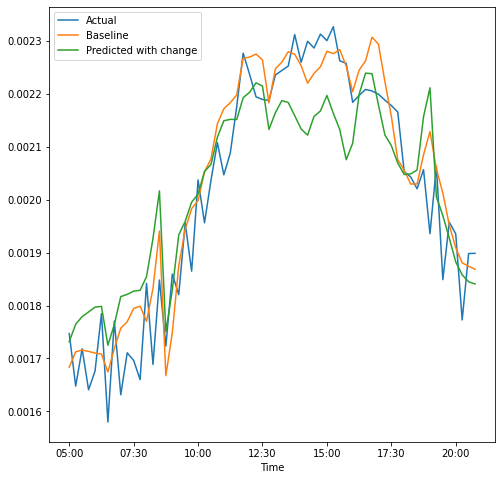

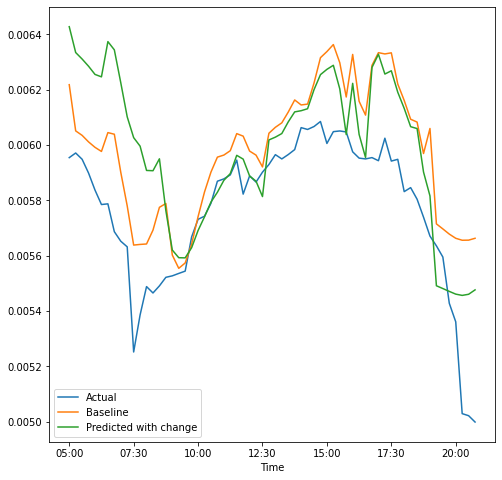

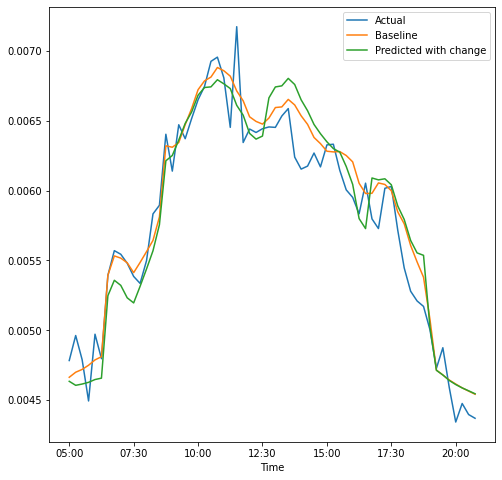

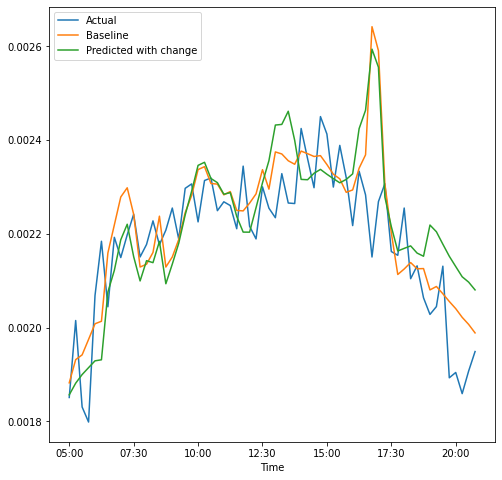

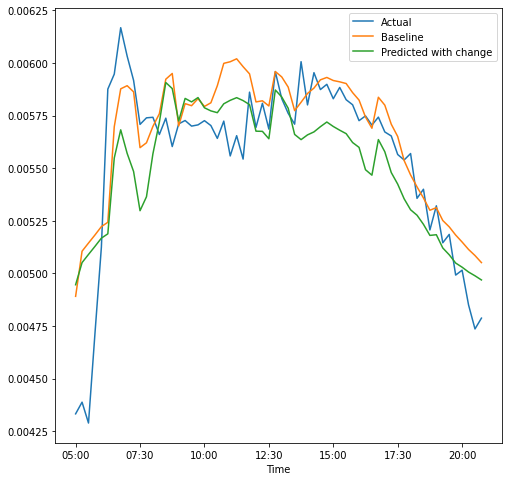

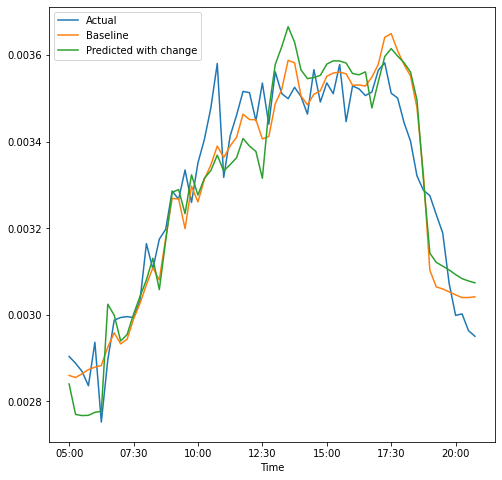

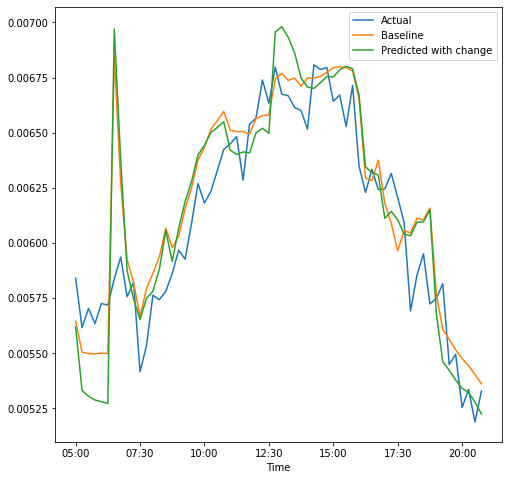

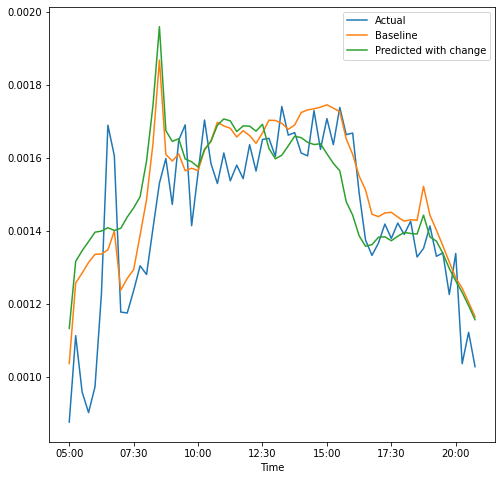

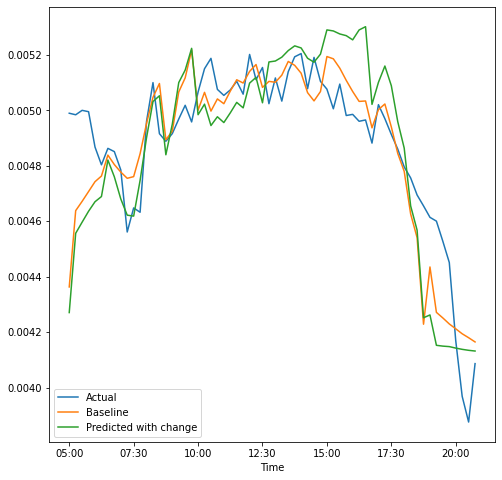

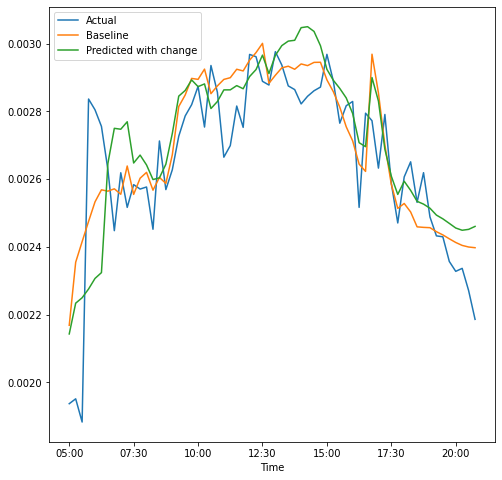

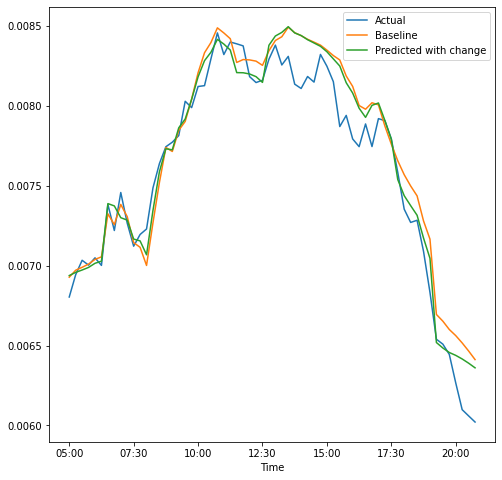

In [294]:
#have to run the dataset codes before running this code
# # User input Building name
# print(Buildings)
# for i in range(len(Buildings)):
#     print(i, Buildings[i])
# bldg= int(input("Enter building from the list above: "))
for bldg in range(len(Buildings)):
    # plot predictions for baseline data data
    date_time = MicroclimateData[['Date_Time',
                            'Month',
                            'Day',
                            'Hour',
                            'Minute']]
    #for baseline results
    comb1 = [X_train, X_test]
    X_train_in = pd.concat(comb1)
    #     print("old X",X_train)
    Y_preds = model.predict(X_train_in)
    y_train_in = np.concatenate((y_train, y_test))
    results_NN = undummify(X_train_in).join(date_time)
    results_NN['Actual'] = StdSc2.inverse_transform(y_train_in)
    results_NN['Baseline'] = StdSc2.inverse_transform(Y_preds)


    #for new data results
    comb2 = [X_train_new, X_test_new]
    X_train_new_in = pd.concat(comb2)
    # print("new X",X_train_new)
    Y_preds_new = model.predict(X_train_new_in)
    # print("new result", Y_preds_new)
    results_NN['Predicted with change'] = StdSc2.inverse_transform(Y_preds_new)
    # print(Y_preds_new)
    
    
    # find out for particular day
    month_NN = results_NN[results_NN['Month'] == 8]
    day_NN = month_NN[month_NN['Day'] == 1]
    bldg_NN = day_NN.loc[day_NN['bldgname'] == Buildings[bldg]]
    bldg_NN['Time'] = bldg_NN['Date_Time'].str[11:16]  
    # print(bldg_NN)
    values_NN = bldg_NN.sort_values(by=['Time'])

    # #plot values_NN
    ax = values_NN.plot(x='Time',y='Actual',grid = False, figsize = (8,8))
    values_NN.plot(x='Time',y='Baseline',grid = False, figsize = (8,8),ax=ax)
    values_NN.plot(x='Time',y='Predicted with change',grid = False, figsize = (8,8),ax=ax)
    string = './Data/Plots/sensitivity analysis/WithTemperatureMod/'+ Buildings[bldg]
    
    plt.savefig(string, bbox_inches='tight')  
